In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
import tensorflow_addons as tfa

In [3]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [4]:
training_data = load_training_data(root_dir="/Users/spx8sk/work/projects/wispy/dev-stack/training_data")

In [5]:
validation_data = load_training_data(root_dir="/Users/spx8sk/work/projects/wispy/dev-stack/validation_data")

In [6]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [7]:
# lets just take the phenomD data for now

In [8]:
training_data['unique_approximants']

array(['IMRPhenomD', 'NR', 'SEOBNRv4_opt'], dtype='<U12')

In [9]:
mask = training_data['mask']['IMRPhenomD']
# mask = training_data['mask']['SEOBNRv4_opt']
y = training_data['amplitude'][mask]
# y = training_data['phase'][mask]
x = training_data['mass_ratios'][mask]
yval = validation_data['amplitude'][mask]
xval = validation_data['mass_ratios'][mask]
times = training_data['times']

# y = training_data['amplitude']
# # y = training_data['phase']
# x = training_data['mass_ratios']

# yval = validation_data['amplitude']
# xval = validation_data['mass_ratios']

# times = training_data['times']

In [10]:
print(y.shape)

(100, 1150)


In [11]:
print(yval.shape)

(100, 1150)


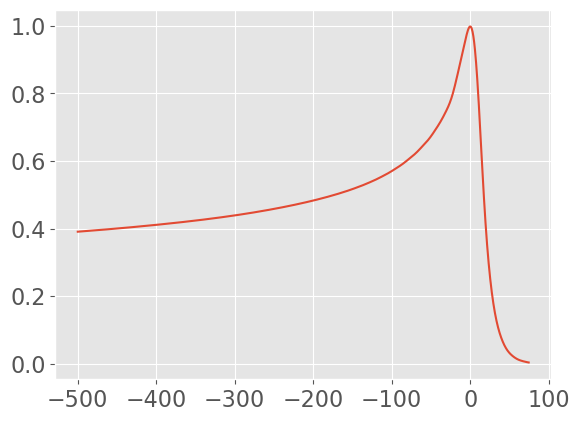

In [12]:
plt.figure()
plt.plot(training_data['times'], y[0])
plt.show()

In [13]:
def build_encoder(input_shape, latent_dim, units, acts):
    # build the encoder
    timeseries_input = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(timeseries_input)
        else:
            x = layers.Dense(unit, activation=act)(x)
    latent_output = layers.Dense(latent_dim)(x)
    encoder_model = keras.Model(timeseries_input, latent_output)
#     print("=" * 20)
#     print("encoder summary")
#     print("=" * 20)
#     encoder_model.summary()

    return encoder_model


def build_decoder(input_shape, latent_dim, units, acts):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(latent_input)
        else:
            x = layers.Dense(unit, activation=act)(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_model = keras.Model(latent_input, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model


def build_and_compile_autoencoder(
    input_shape, encoder_model, decoder_model, opt, loss, metrics
):
    # build the AE
    timeseries_input = keras.Input(shape=(input_shape,))
    latent = encoder_model(timeseries_input)
    timeseries_output = decoder_model(latent)
    ae_model = keras.Model(timeseries_input, timeseries_output)
#     print("=" * 20)
#     print("autoencoder summary")
#     print("=" * 20)
#     ae_model.summary()

    ae_model.compile(optimizer=opt, loss=loss, metrics=metrics)

    return ae_model




In [14]:
%%time
input_shape = y.shape[1]
latent_dim = 1
encoder_units = [128, 16]
encoder_acts = ['relu', 'relu']

decoder_units = [16, 128]
decoder_acts = ['relu', 'relu']

# decoder_units = [16, 128, 128, 128]
# decoder_acts = ['relu', 'relu', 'relu', 'relu']

loss = 'mae'
metrics = ['mse']

opt = tf.keras.optimizers.Adam(1e-3)

encoder_model = build_encoder(input_shape, latent_dim, encoder_units, encoder_acts)
decoder_model = build_decoder(input_shape, latent_dim, decoder_units, decoder_acts)
ae_model = build_and_compile_autoencoder(
    input_shape, encoder_model, decoder_model, opt, loss, metrics
)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

# history = ae_model.fit(y, y, epochs=10000, callbacks=callbacks, verbose=0, validation_data=(yval, yval))
history = ae_model.fit(y, y, epochs=1000, callbacks=callbacks, verbose=0, validation_data=(yval, yval))


CPU times: user 56.5 s, sys: 7.24 s, total: 1min 3s
Wall time: 46.2 s


In [15]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

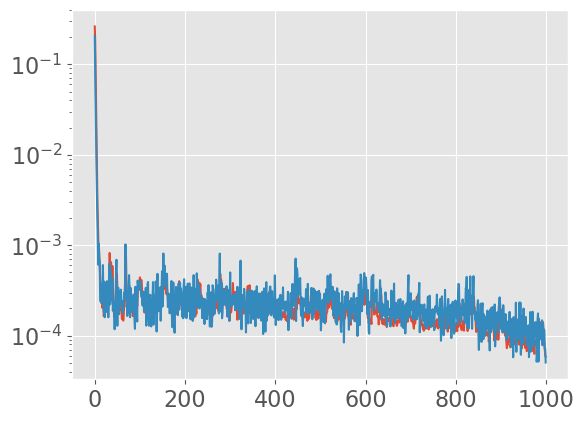

In [16]:
plt.figure()
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.yscale('log')
plt.show()
plt.close()

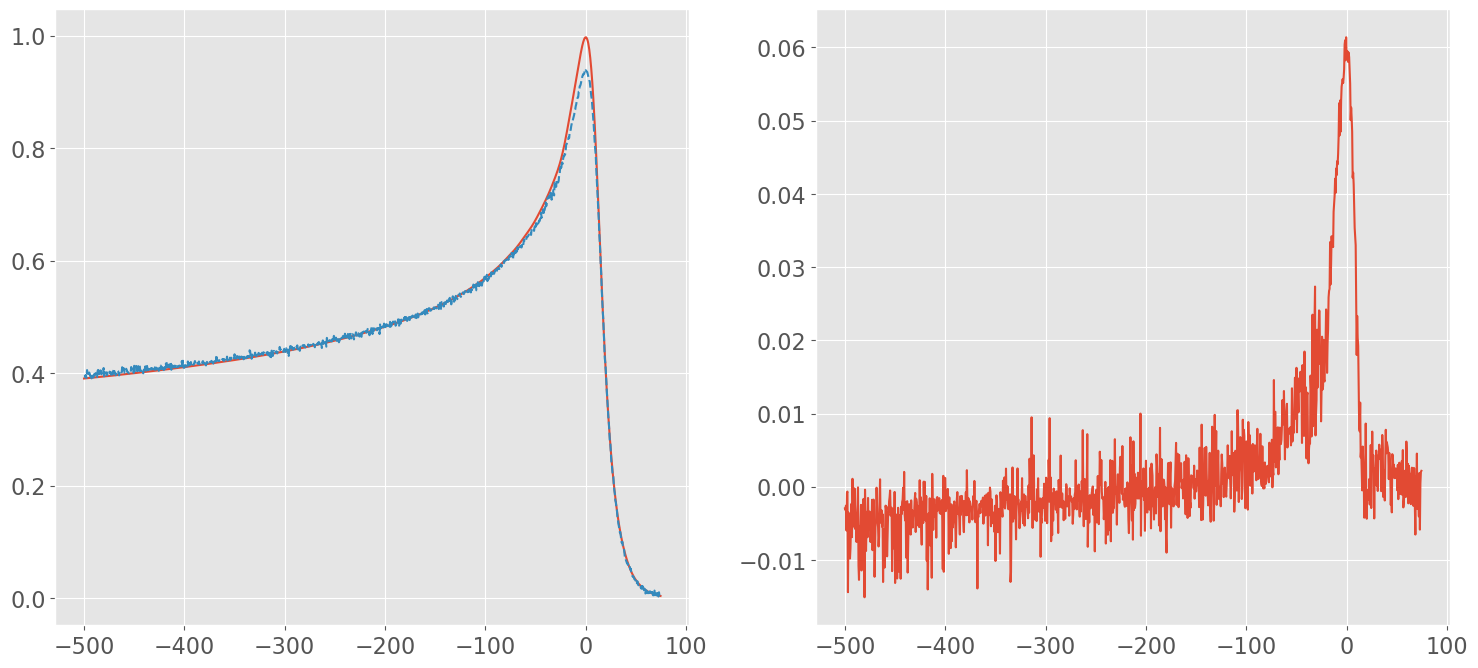

In [17]:
index = 0
yhat = ae_model.predict(y)[index]
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[index])
plt.plot(times, yhat, ls='--')

plt.subplot(1, 2, 2)
plt.plot(times, y[index]-yhat)
plt.show()
plt.close()

In [18]:
latent_space = encoder_model.predict(y)

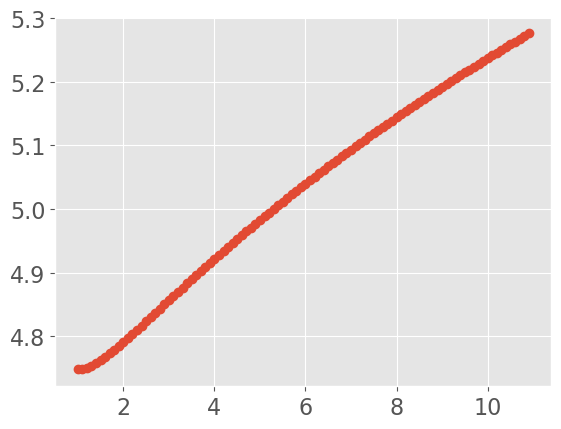

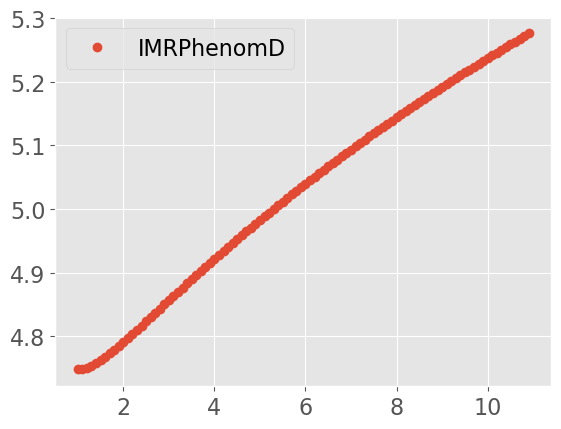

In [20]:
plt.figure()
plt.plot(x[training_data['mask']["IMRPhenomD"]], latent_space[training_data['mask']["IMRPhenomD"], 0], 'o', label='IMRPhenomD')
# plt.plot(x[training_data['mask']["SEOBNRv4_opt"]], latent_space[training_data['mask']["SEOBNRv4_opt"], 0], 'o', label='SEOBNRv4_opt')
# plt.plot(x[training_data['mask']["NR"]], latent_space[training_data['mask']["NR"], 0], 'o', label='NR')
plt.legend()
plt.show()

# construct residuals

In [21]:
yRes = y-ae_model.predict(y)

In [22]:
yRes_val = yval-ae_model.predict(yval)

In [23]:
yRes.shape

(100, 1150)

In [24]:
yRes_val.shape

(100, 1150)

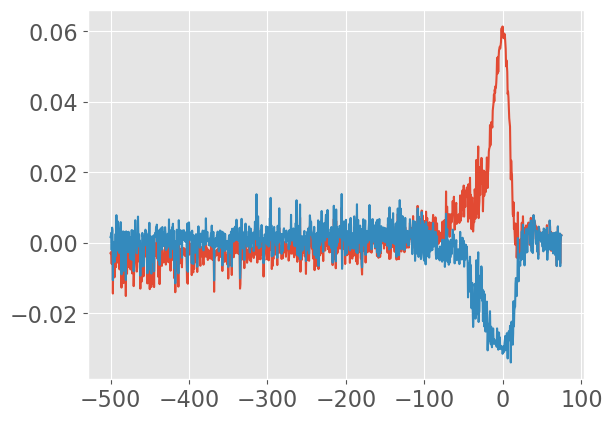

In [25]:
plt.figure()
plt.plot(times, yRes[0])
plt.plot(times, yRes[-1])
# plt.plot(times, yRes_val[-1])
plt.show()
plt.close()

In [26]:
def get_later_model_ae(y, yval, epochs=1000):
    input_shape = y.shape[1]
    latent_dim = 2
    encoder_units = [128, 16]
    encoder_acts = ['relu', 'relu']

    decoder_units = [16, 128]
    decoder_acts = ['relu', 'relu']

    # decoder_units = [16, 128, 128, 128]
    # decoder_acts = ['relu', 'relu', 'relu', 'relu']

    loss = 'mae'
    metrics = ['mse']

    opt = tf.keras.optimizers.Adam(1e-3)

    encoder_model = build_encoder(input_shape, latent_dim, encoder_units, encoder_acts)
    decoder_model = build_decoder(input_shape, latent_dim, decoder_units, decoder_acts)
    ae_model = build_and_compile_autoencoder(
        input_shape, encoder_model, decoder_model, opt, loss, metrics
    )

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    # history = ae_model.fit(y, y, epochs=10000, callbacks=callbacks, verbose=0, validation_data=(yval, yval))
    history = ae_model.fit(y, y, epochs=epochs, callbacks=callbacks, verbose=0, validation_data=(yval, yval))
    
    return history, ae_model, encoder_model, decoder_model

In [27]:
# def get_later_model(x, y, input_shape, output_shape, validation_data, batch_size=32, epochs=1000, act='relu'):

#     model = tf.keras.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(input_shape,)),
#         tf.keras.layers.Dense(128, activation=act),
#         tf.keras.layers.Dense(16, activation=act),
#         tf.keras.layers.Dense(8, activation='linear'),
#         tf.keras.layers.Dense(16, activation=act),
#         tf.keras.layers.Dense(128, activation=act),
#         tf.keras.layers.Dense(output_shape)
#     ])
    
#     optimizer = tf.keras.optimizers.Adam(0.001)
# #     optimizer = tfa.optimizers.LazyAdam(0.001)
#     model.compile(loss = 'mae', metrics = ['mse'], optimizer=optimizer)

#     callbacks=[]
#     tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
#     callbacks.append(tqdm_callback)
    
#     history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=callbacks, validation_data=validation_data)
    
#     return history, model

In [28]:
%%time
history_2, model_2, encoder_model_2, decoder_model_2 = get_later_model_ae(yRes, yRes_val, epochs=2000)


CPU times: user 2min 4s, sys: 14.6 s, total: 2min 18s
Wall time: 1min 44s


In [ ]:
# %%time
# history_2, model_2 = get_later_model(yRes, yRes, yRes.shape[1], yRes.shape[1], (yRes_val, yRes_val))

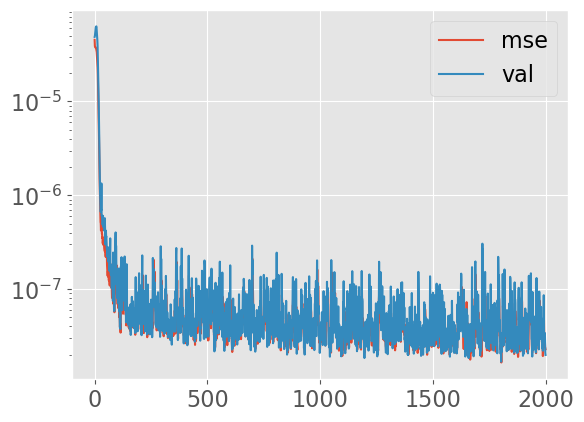

In [29]:
plt.figure()
plt.plot(history_2.history['mse'], label='mse')
plt.plot(history_2.history['val_mse'], label='val')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

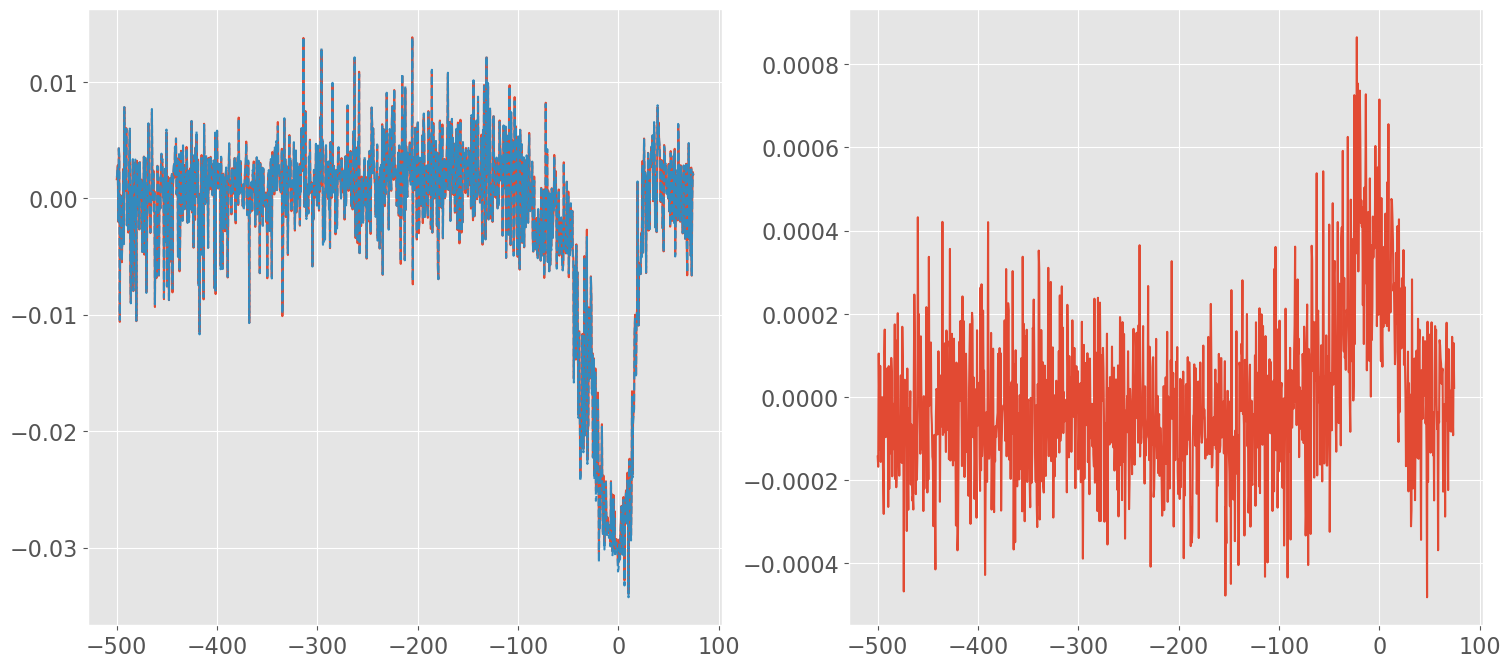

In [30]:
index = -1
yhat = model_2.predict(yRes)[index]
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, yRes[index])
plt.plot(times, yhat, ls='--')

plt.subplot(1, 2, 2)
plt.plot(times, yRes[index]-yhat)
plt.show()
plt.close()

In [67]:
def final_prediction(index):
    
    yhat1 = ae_model.predict(y)
    
    yhat2 = model_2.predict(y-yhat1)
    yhat = yhat1 + yhat2
    yhat1 = yhat1[index]
    yhat2 = yhat2[index]
    yhat = yhat[index]

    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    plt.plot(times, y[index])
    plt.plot(times, yhat1)
#     plt.plot(times, yhat2)
    plt.plot(times, yhat, ls='--')
    
    plt.subplot(1, 2, 2)
    plt.plot(times, y[index]-yhat1, label='initial')
    plt.plot(times, y[index]-yhat, label='step2')
    plt.legend()
    plt.show()
    plt.close()

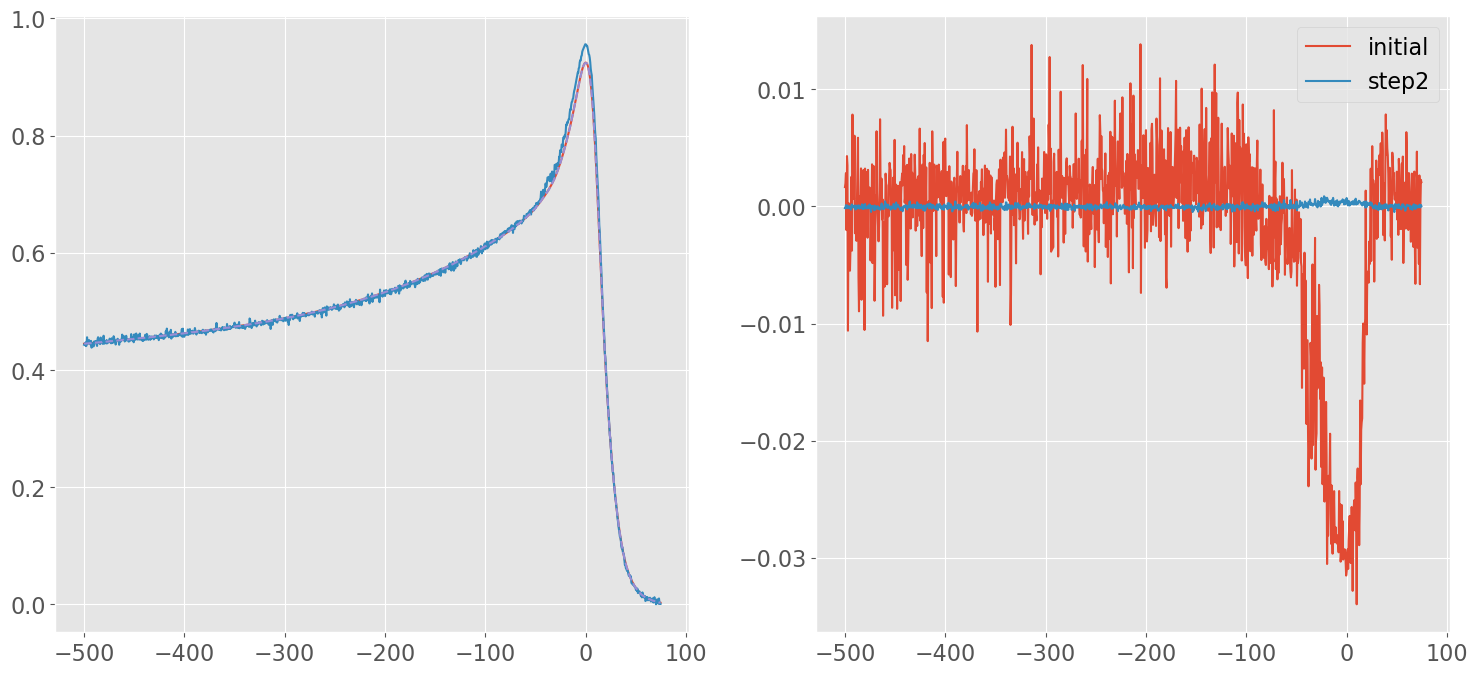

In [68]:
final_prediction(-1)

In [37]:
latent_space_2 = encoder_model_2.predict(yRes)

In [38]:
latent_space_2.shape

(100, 2)

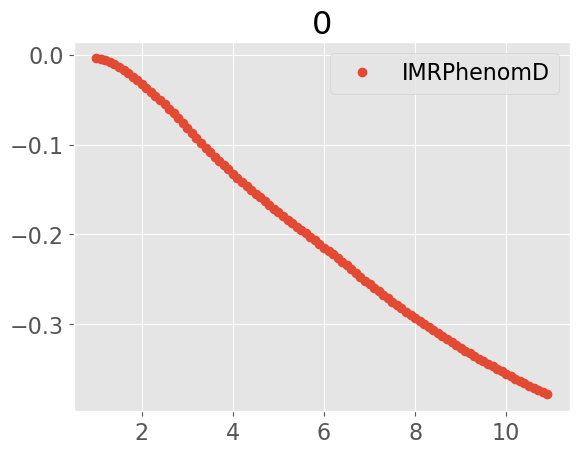

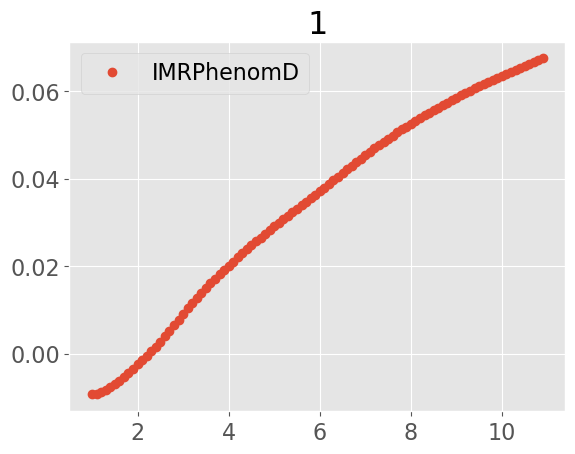

In [41]:
for i in range(latent_space_2.shape[1]):
    plt.figure()
    plt.plot(x[training_data['mask']["IMRPhenomD"]], latent_space_2[training_data['mask']["IMRPhenomD"], i], 'o', label='IMRPhenomD')
#     plt.plot(x[training_data['mask']["SEOBNRv4_opt"]], latent_space_2[training_data['mask']["SEOBNRv4_opt"], i], 'o', label='SEOBNRv4_opt')
#     plt.plot(x[training_data['mask']["NR"]], latent_space_2[training_data['mask']["NR"], i], 'o', label='NR')
    plt.legend()
    plt.title(i)
    plt.show()

# model residual as a function of q?

In [ ]:
# note that this doesn't work with the whole training set because the function
# is multivalued and the fit method doesn't like that.
# what i mean is that for mass-ratio 1 there are three waveforms: phenD, EOB and NR.
# need to either fit each one separately or embed them using an autoencoder.

In [ ]:
# this CAN work if you either:
# 1. just have a single model or 
# 2. encoder the model as another input variable

In [42]:
def get_later_model_q(x, y, input_shape, output_shape, validation_data, batch_size=32, epochs=1000):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_shape,)),
        tf.keras.layers.Dense(128*2, activation='tanh'),
        tf.keras.layers.Dense(128*2, activation='tanh'),
        tf.keras.layers.Dense(128*2, activation='tanh'),
        tf.keras.layers.Dense(128*2, activation='tanh'),
#         tf.keras.layers.Dense(128*2, activation='relu'),
#         tf.keras.layers.Dense(128*2, activation='relu'),
#         tf.keras.layers.Dense(128*2, activation='relu'),
#         tf.keras.layers.Dense(128*2, activation='relu'),
#         tf.keras.layers.Dense(128*2, activation='relu'),
#         tf.keras.layers.Dense(128*2, activation='relu'),
#         tf.keras.layers.Dense(128*2, activation='relu'),
#         tf.keras.layers.Dense(128*2, activation='relu'),
        tf.keras.layers.Dense(output_shape)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
#     optimizer = tfa.optimizers.LazyAdam(0.001)
    model.compile(loss = 'mae', metrics = ['mse'], optimizer=optimizer)
#     model.compile(loss = 'mse', metrics = ['mse'], optimizer=optimizer)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=callbacks, validation_data=validation_data)
    
    return history, model

In [43]:
# %%time
# history_2_q, model_2_q = get_later_model_q(x[:,np.newaxis], yRes, 1, yRes.shape[1], epochs=5000)

In [44]:
x_new = x[:,np.newaxis]
y_new = yRes

In [45]:
print(x_new.shape)
print(y_new.shape)

(100, 1)
(100, 1150)


In [57]:
history_2_q, model_2_q = get_later_model_q(x_new, y_new, x_new.shape[1], y_new.shape[1], epochs=5000, validation_data=(xval, yRes_val))

In [69]:
model_2_q.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               512       
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_26 (Dense)             (None, 1150)              295550    
Total params: 493,438
Trainable params: 493,438
Non-trainable params: 0
_________________________________________________________________


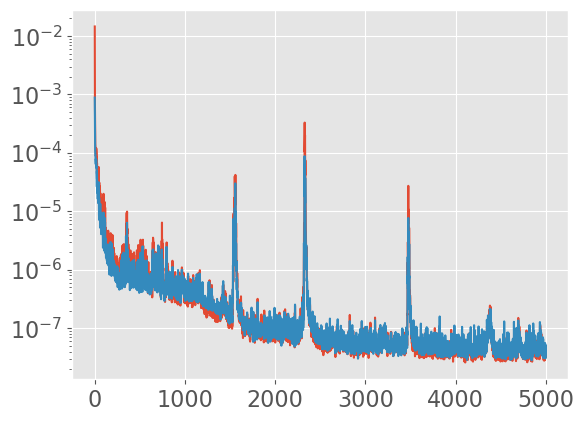

In [58]:
plt.figure()
plt.plot(history_2_q.history['mse'])
plt.plot(history_2_q.history['val_mse'])
plt.yscale('log')
plt.show()
plt.close()

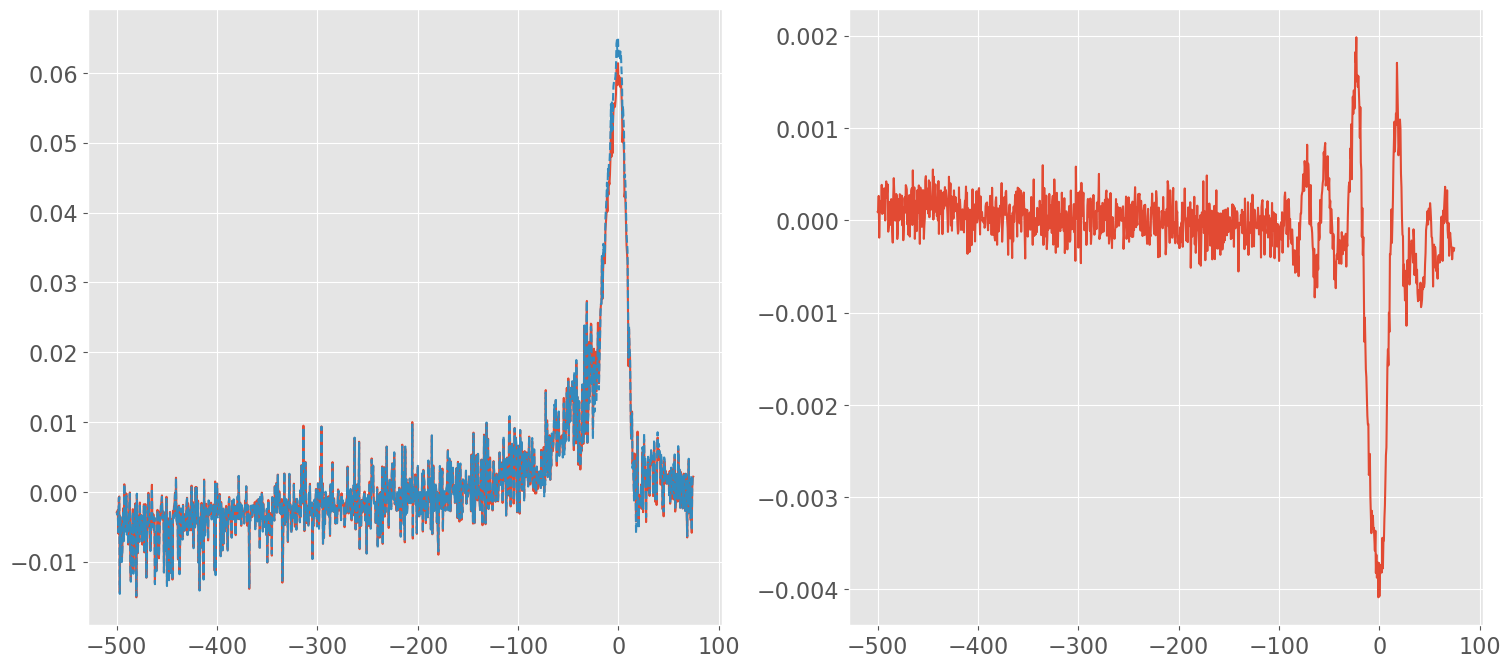

In [59]:
index = 0
# index = 101
# yhat = model_2.predict(yRes)[index]

yhat = model_2_q.predict(x)[index]

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, yRes[index])
plt.plot(times, yhat, ls='--')

plt.subplot(1, 2, 2)
plt.plot(times, yRes[index]-yhat)
plt.show()
plt.close()

In [60]:
def final_prediction_2(index):
    
    yhat1 = ae_model.predict(y)
    
    yhat2 = model_2_q.predict(x)
    
    yhat = yhat1 + yhat2
    yhat1 = yhat1[index]
    yhat2 = yhat2[index]
    yhat = yhat[index]

    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    plt.plot(times, y[index])
    plt.plot(times, yhat1)
#     plt.plot(times, yhat2)
    plt.plot(times, yhat, ls='--')
    
    plt.subplot(1, 2, 2)
    plt.plot(times, y[index]-yhat1, label='initial')
    plt.plot(times, y[index]-yhat, label='step2')
    plt.legend()
    plt.show()
    plt.close()

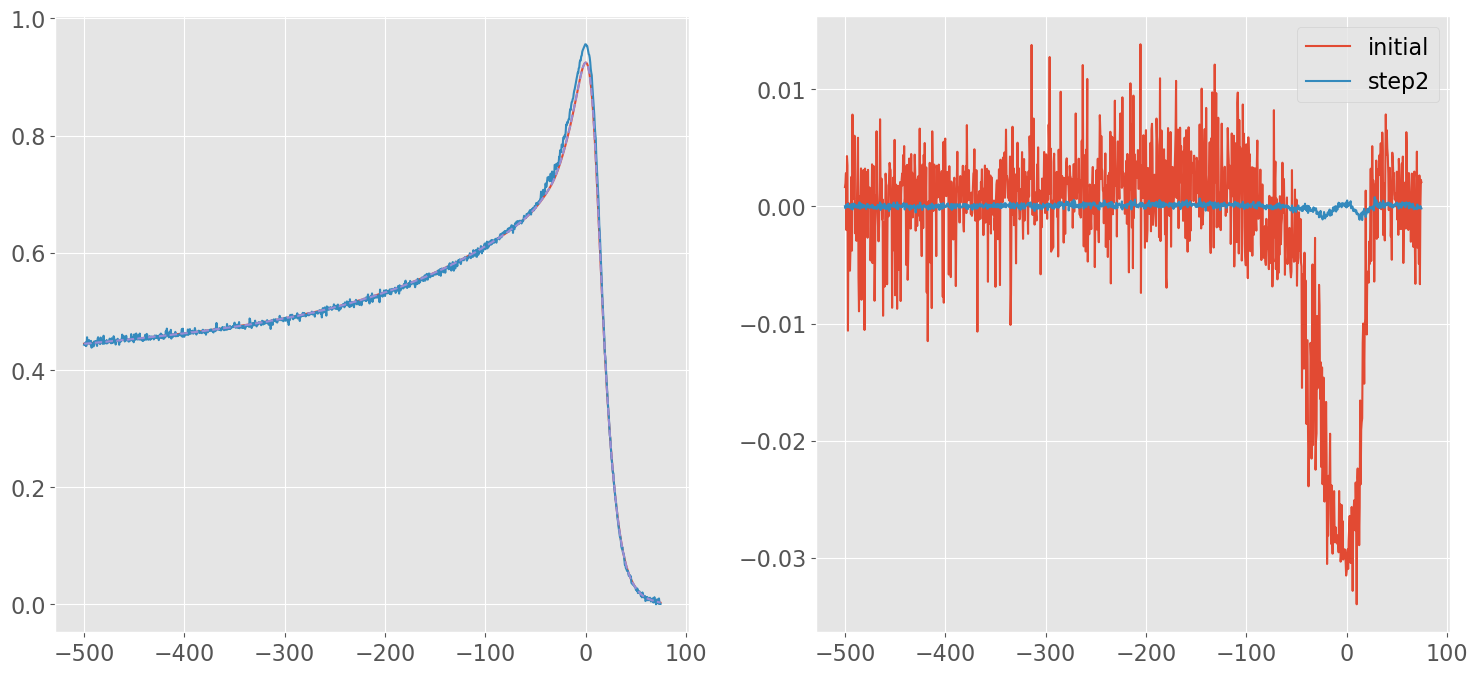

In [63]:
final_prediction_2(-1)